In [1]:
from transformers import BartForConditionalGeneration, BartConfig
from transformers import RobertaTokenizerFast
import torch
from torch.utils.data import DataLoader

from miditok import REMI, TokenizerConfig, TokSequence
from pathlib import Path

from models import MelCAT_base
from dataset_utils import LiveMelCATDataset, MelCATCollator

from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

import os
import numpy as np
import csv

import symusic

from tqdm import tqdm

MAX_LENGTH = 1024

roberta_tokenizer_midi = RobertaTokenizerFast.from_pretrained('/media/datadisk/data/pretrained_models/midi_mlm_tiny/midi_wordlevel_tokenizer')

bart_config = BartConfig(
    vocab_size=roberta_tokenizer_midi.vocab_size,
    pad_token_id=roberta_tokenizer_midi.pad_token_id,
    bos_token_id=roberta_tokenizer_midi.bos_token_id,
    eos_token_id=roberta_tokenizer_midi.eos_token_id,
    decoder_start_token_id=roberta_tokenizer_midi.bos_token_id,
    forced_eos_token_id=roberta_tokenizer_midi.eos_token_id,
    max_position_embeddings=MAX_LENGTH,
    encoder_layers=8,
    encoder_attention_heads=16,
    encoder_ffn_dim=4096,
    decoder_layers=8,
    decoder_attention_heads=16,
    decoder_ffn_dim=4096,
    d_model=256,
    encoder_layerdrop=0.3,
    decoder_layerdrop=0.3,
    dropout=0.3
)

run_on_gpu = True

if run_on_gpu:
    dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MelCAT_base(bart_config, gpu=0).to(dev)
    checkpoint = torch.load('saved_models/bart_base/bart_base.pt', weights_only=True)
else:
    dev = torch.device("cpu")
    model = MelCAT_base(bart_config, gpu=None).to(dev)
    checkpoint = torch.load('saved_models/bart_base/bart_base.pt', map_location="cpu", weights_only=True)

model.load_state_dict(checkpoint)

model.eval()

/home/maximos/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at /media/datadisk/data/pretrained_models/midi_mlm_tiny/checkpoint-46080 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at /media/datadi

MelCAT_base(
  (text_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [2]:
midifolder = '/media/datadisk/datasets/GiantMIDI-PIano/midis_v1.2/midis'
# midifolder = '/media/datadisk/data/Giant_PIano/'
dataset = LiveMelCATDataset(midifolder, segment_size=40, resolution=4, max_seq_len=1024, only_beginning=True)

/home/maximos/anaconda3/envs/torch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
custom_collate_fn = MelCATCollator(max_seq_lens=dataset.max_seq_lengths, padding_values=dataset.padding_values)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=custom_collate_fn, drop_last=True)

In [4]:
# d = next(iter(dataloader))
# print(d)
i = 0
for d in dataloader:
    if i == 3:
        break
    i += 1
print(d)

{'melody': {'input_ids': tensor([[ 26,  70, 157,   5,  12,  26,  26,  26,  26,  26,  26,  26,  26,  92,
          37,  13,  11,   5,  14,   5,   9,  66,  55,  16,  11,   5,  12,   5,
           9,  94,  52,  16,   7,   5,  10,   5,   6,  62,  55,  16,   7,   5,
          25,   5,   6,  93,  59,  13,  11,   5,  14,   5,   9,  26,  66,  96,
          15,  11,   5,  10,   5,   9,  93,  44,  16,   7,   5,   9,   5,   6]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, 'chroma': {'input_ids': tensor([[25, 17,  9, 16,  5, 13,  8, 10, 14,  6, 15,  7, 12, 11, 17,  9, 16,  5,
         13,  8, 10, 14,  6, 15,  7, 12, 11, 17,  9, 16,  5, 13,  8, 10, 14,  6,
         15,  7, 12, 11, 17,  9, 16,  5, 13,  8, 10, 14,  6, 15,  7, 12, 11, 17,
          9, 16,  5, 13,  8, 10, 14,  6, 15,  7, 12

In [5]:
print(d['accomp'])

{'input_ids': tensor([[ 26,  70, 157,   5,  12,  26,  26,  26,  26,  26,  26,  26,  26,  92,
          46,  16,   7,   5,  10,   5,   6,  61,  49,  16,   7,   5,   9,   5,
           6,  66,  35,  16,  11,   5,  12,   5,   9,  38,  18,  11,   5,  12,
           5,   9,  88,  98,  16,   7,   5,  25,   5,   6,  62,  49,  16,   7,
           5,  25,   5,   6,  93,  35,  15,   7,   5,  25,   5,   6,  26,  92,
          34,  15,   7,   5,   9,   5,   6,  66,  37,  13,  29,   5,  12,   5,
          10,  88,  46,  13,   7,   5,  10,   5,   6,  94,  49,  13,   7,   5,
          10,   5,   6,  62,  35,  13,   7,   5,  25,   5,   6,  93,  49,  13,
           7,   5,   9,   5,   6]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [46]:
print(d['accomp']['input_ids'][0])
toks = roberta_tokenizer_midi.convert_ids_to_tokens(d['accomp']['input_ids'][0])
print(toks)

tensor([ 26,  70, 157,   5,  12,  26,  26,  26,  26,  26,  26,  26,  26,  92,
         46,  16,   7,   5,  10,   5,   6,  61,  49,  16,   7,   5,   9,   5,
          6,  66,  35,  16,  11,   5,  12,   5,   9,  38,  18,  11,   5,  12,
          5,   9,  88,  98,  16,   7,   5,  25,   5,   6,  62,  49,  16,   7,
          5,  25,   5,   6,  93,  35,  15,   7,   5,  25,   5,   6,  26,  92,
         34,  15,   7,   5,   9,   5,   6,  66,  37,  13,  29,   5,  12,   5,
         10,  88,  46,  13,   7,   5,  10,   5,   6,  94,  49,  13,   7,   5,
         10,   5,   6,  62,  35,  13,   7,   5,  25,   5,   6,  93,  49,  13,
          7,   5,   9,   5,   6])
['bar_none', 'position_0', 'tempo_125', '.', '0', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'position_4', 'pitch_57', 'velocity_79', 'duration_0', '.', '2', '.', '8', 'position_6', 'pitch_58', 'velocity_79', 'duration_0', '.', '4', '.', '8', 'position_10', 'pitch_60', 'velocity_79', 'dur

In [6]:
bos_input = {
    'input_ids' : torch.LongTensor([[roberta_tokenizer_midi.bos_token_id]]),
    'attention_mask' : torch.LongTensor([[1]])
}
logits = model(d['text'], d['melody'], d['chroma'], bos_input)
logits_full = model(d['text'], d['melody'], d['chroma'], d['accomp'])

In [7]:
import matplotlib.pyplot as plt

torch.Size([1, 1, 170])


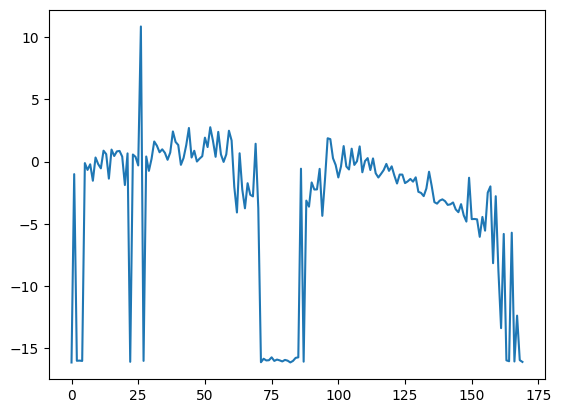

In [10]:
print(logits.shape)
plt.plot(logits[0,-1,:].cpu().detach().numpy())

torch.Size([1, 1, 170])


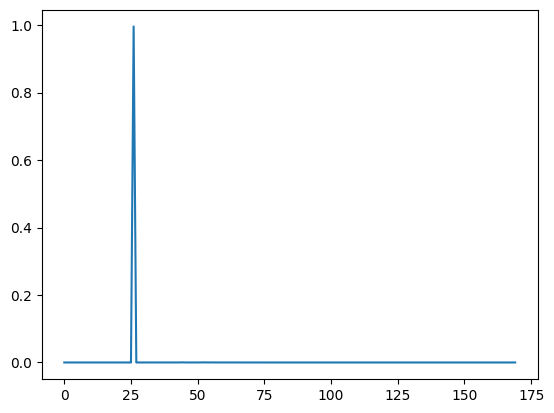

In [13]:
logits_softmax = F.softmax(logits, dim=-1)
print(logits_softmax.shape)
plt.plot(logits_softmax[0,-1,:].cpu().detach().numpy())

In [14]:
def sample_with_temperature(logits, temperature=1.0):
    # Scale logits by temperature
    logits = logits / temperature
    # Apply softmax to get probabilities
    probs = F.softmax(logits, dim=-1)

    # Flatten the logits if necessary
    batch_size, seq_len, vocab_size = probs.shape
    probs = probs.view(-1, vocab_size)  # Merge batch_size and seq_len dimensions
    
    # Sample from the probability distribution
    sampled_tokens = torch.multinomial(probs, num_samples=1)
    
    # Reshape back to [batch_size, seq_len, 1]
    sampled_tokens = sampled_tokens.view(batch_size, seq_len, 1)

    # # Sample from the probability distribution
    # sampled_token = torch.multinomial(probs, num_samples=1)
    return sampled_tokens

In [15]:
sampled_full = sample_with_temperature(logits_full)
print(logits_full.shape)
print(sampled_full.shape)
print(sampled_full[:][-1][:].reshape(1,-1).shape)

torch.Size([1, 117, 170])
torch.Size([1, 117, 1])
torch.Size([1, 117])


In [18]:
temperature = 0.7  # Adjust temperature as needed
sampled_tokens = sample_with_temperature(logits, temperature)
print(sampled_tokens[0][-1:])
print(bos_input['input_ids'])
xx = torch.cat( (bos_input['input_ids'].to(dev), sampled_tokens[0][-1:].to(dev)), -1 )

tensor([[26]], device='cuda:0')
tensor([[1]])


In [19]:
print(xx)

tensor([[ 1, 26]], device='cuda:0')


In [20]:
print(sampled_tokens[0][0][-1])
print(roberta_tokenizer_midi.eos_token_id)
print(sampled_tokens[0][0][-1] != roberta_tokenizer_midi.eos_token_id)

tensor(26, device='cuda:0')
2
tensor(True, device='cuda:0')


In [23]:
x = torch.cat( (bos_input['input_ids'].to(dev), sampled_tokens[:][:][-1].to(dev)), -1)

In [24]:
print(x.shape)
print(d['accomp']['input_ids'].shape)

torch.Size([1, 2])
torch.Size([1, 117])


In [25]:
attx = torch.cat( (bos_input['attention_mask'], torch.full(sampled_tokens[0].shape,1)), -1)

In [26]:
bos_input = {
    'input_ids' : xx,
    'attention_mask' : attx
}
logits = model(d['text'], d['melody'], d['chroma'], bos_input)
logits_full = model(d['text'], d['melody'], d['chroma'], d['accomp'])

In [27]:
print(logits.shape)

torch.Size([1, 2, 170])


In [32]:
def generate_bart_base(d, temperature=1.0, max_seq_len=4096):
    accomp_input = {
        'input_ids' : torch.LongTensor([[roberta_tokenizer_midi.bos_token_id]]),
        'attention_mask' : torch.LongTensor([[1]])
    }
    logits = model(d['text'], d['melody'], d['chroma'], accomp_input)
    sampled_tokens = sample_with_temperature(logits, temperature)
    while sampled_tokens[0][0][-1] != roberta_tokenizer_midi.eos_token_id and accomp_input['input_ids'].shape[-1] < max_seq_len:
        print(accomp_input['input_ids'].shape[-1], end='\r')
        accomp_input['input_ids'] = torch.cat( (accomp_input['input_ids'].to(dev), sampled_tokens[0][-1:].to(dev)), -1)
        accomp_input['attention_mask'] = torch.cat( (accomp_input['attention_mask'].to(dev), torch.full(sampled_tokens[0][-1:].shape,1).to(dev)), -1)
        logits = model(d['text'], d['melody'], d['chroma'], accomp_input)
        sampled_tokens = sample_with_temperature(logits, temperature)
    return accomp_input

In [33]:
a = generate_bart_base(d)

In [34]:
print(a['input_ids'].shape)

torch.Size([1, 4096])


In [35]:
print(a['input_ids'][0])
toks = roberta_tokenizer_midi.convert_ids_to_tokens(a['input_ids'][0])
print(toks)

tensor([ 1, 26, 70,  ...,  8,  5, 92], device='cuda:0')
['<s>', 'bar_none', 'position_0', 'tempo_125', '.', '0', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'position_12', 'pitch_58', 'velocity_68', 'duration_1', '.', '2', '.', '4', 'position_16', 'pitch_46', 'velocity_52', 'duration_1', '.', '2', '.', '4', 'position_22', 'pitch_51', 'velocity_58', 'duration_2', '.', '1', '.', '2', 'position_24', 'pitch_53', 'velocity_63', 'duration_1', '.', '2', '.', '4', 'bar_none', 'position_6', 'pitch_53', 'velocity_63', 'duration_1', '.', '1', '.', '4', 'position_12', 'pitch_50', 'velocity_68', 'duration_0', '.', '2', '.', '8', 'position_14', 'pitch_53', 'velocity_74', 'duration_1', '.', '2', '.', '4', 'position_18', 'pitch_53', 'velocity_63', 'duration_0', '.', '2', '.', '8', 'position_20', 'pitch_58', 'velocity_74', 'duration_1', '.', '1', '.', '4', 'pitch_65', 'velocity_74', 'duration_1', '.', '2', '.', '4', 'pitch_70', 'velocity_7

In [36]:
remi_tokenizer = REMI(params=Path('/media/datadisk/data/pretrained_models/midis_REMI_BPE_tokenizer.json'))

In [37]:
toks_miditok = []
for tok in toks:
    if '_' in tok:
        toks_miditok.append(tok)
tok_seq = TokSequence(toks_miditok)

In [38]:
print(tok_seq)

TokSequence(tokens=['bar_none', 'position_0', 'tempo_125', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'bar_none', 'position_12', 'pitch_58', 'velocity_68', 'duration_1', 'position_16', 'pitch_46', 'velocity_52', 'duration_1', 'position_22', 'pitch_51', 'velocity_58', 'duration_2', 'position_24', 'pitch_53', 'velocity_63', 'duration_1', 'bar_none', 'position_6', 'pitch_53', 'velocity_63', 'duration_1', 'position_12', 'pitch_50', 'velocity_68', 'duration_0', 'position_14', 'pitch_53', 'velocity_74', 'duration_1', 'position_18', 'pitch_53', 'velocity_63', 'duration_0', 'position_20', 'pitch_58', 'velocity_74', 'duration_1', 'pitch_65', 'velocity_74', 'duration_1', 'pitch_70', 'velocity_74', 'duration_1', 'position_28', 'pitch_52', 'velocity_68', 'duration_1', 'position_30', 'pitch_55', 'velocity_58', 'duration_0', 'pitch_76', 'velocity_63', 'duration_0', 'bar_none', 'position_2', 'pitch_53', 'velocity_58', 'duration_1', 'pitch_58', 'vel

In [39]:
m = remi_tokenizer.tokens_to_midi(tokens=[tok_seq])

/tmp/ipykernel_681/2386078323.py:1: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  m = remi_tokenizer.tokens_to_midi(tokens=[tok_seq])


In [40]:
print(m)

Score(ttype=Tick, tpq=8, begin=0, end=0, tracks=0, notes=0, time_sig=1, key_sig=0, markers=0)


In [41]:
m.dump_midi("out.mid")

In [42]:
s = symusic.Score("out.mid")

In [43]:
print(s)

Score(ttype=Tick, tpq=8, begin=0, end=0, tracks=0, notes=0, time_sig=1, key_sig=0, markers=0)
